# Librerias y datos

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils as ut

path = "data/ARIA_merged&selected/"

show = 0
pat = ut.leer_csv(path + "Patient_real.csv", show)
cur = ut.leer_csv(path + "Course_pi_diag.csv", show)
rtp = ut.leer_csv(path + "RTPlan_PS_Pres.csv", show)
rad = ut.leer_csv(path + "Radiation.csv", show)

sch = ut.leer_csv(path + "SchActivity.csv", show)

diag_pri = ut.leer_csv(path + "Diagnosis_pri.csv", show)
diag_sec = ut.leer_csv(path + "Diagnosis_sec.csv", show)

tr = ut.leer_csv(path + "TreatmentRecord.csv", show)

sch_plan = ut.leer_csv(path + "Sch_Plan.csv", show)

D:\miniconda3\envs\tfm2\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (30,41) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# rtp
### Join

In [2]:
rtp2 = rtp.merge(cur, on="CourseSer", how="left").merge(pat, on="PatientSer", how="left")

### Limpieza

In [3]:
c_index = "RTPlanSer"
c_elim = ["PlanSetupSer","SeriesSer","CourseSer","PatientSer","PrescriptionSer"]
c_fechas = ["StartDateTime"]
c_num = []
c_nans = []

nun_th = 20 # si alguna variable tiene mas que esta cantidad de valores unicos, se agrupan los restantes en una categoria
len_th = 40 # si algun campo es texto con longitud mayor a esta cantidad, se corta y añade su hash al final
num_div = 5 # divisiones en las que se va a divir para convertir variables numericas a categoricas

rtp3, c_categ, elim, res = ut.limpiar_tabla(rtp2, c_index, c_elim, c_fechas, c_num, c_nans, nun_th, len_th, num_div)
# res.sort_values(by="nans")

Se eliminaron 22 columnas y 0 registros


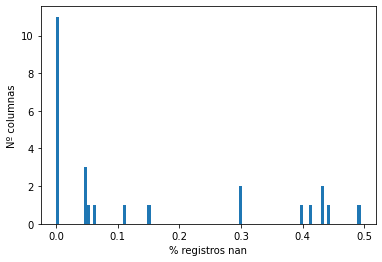

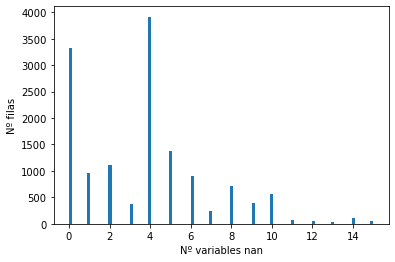

(14157, 26)


In [11]:
rtp4, a, b = ut.quitar_nans(rtp3, 0.5, 1, True)
print(rtp4.shape)

In [14]:
rtp4.to_csv("data/ARIA_cleaned/PlanRT_red.csv", index=True)

# Sch + rtp
### Join

In [41]:
aux = rtp.merge(cur, on="CourseSer", how="left")
p4 = aux.PatientSer.value_counts()[aux.PatientSer.value_counts()==1].index # pacientes con un solo plan

In [42]:
sch["ScheduledStartTime"] = pd.to_datetime(sch["ScheduledStartTime"])
sch["ScheduledEndTime"] = pd.to_datetime(sch["ScheduledEndTime"])
sch["ActualStartDate"] = pd.to_datetime(sch["ActualStartDate"])
sch["ActualEndDate"] = pd.to_datetime(sch["ActualEndDate"])

In [43]:
sch2 = sch[(sch.PatientSer.isin(p4)) & (sch.ActualEndDate.notnull()) & (sch.ScheduledEndTime.notnull())\
          & (sch.ActualStartDate.notnull()) & (sch.ScheduledStartTime.notnull()) & (sch.ActualStartDate != sch.ActualEndDate)]

sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60
sch2 = sch2[(sch2.ActualDuration>1) & (sch2.ActualDuration<60)]

sch2 = sch2.drop(columns = ["ScheduledEndTime","ScheduledStartTime","ActualEndDate","ActualStartDate"])
sch2 = sch2.merge(pat, on="PatientSer", how="left").merge(rtp, on="CourseSer", how="left").merge(cur,on='CourseSer',how='left')
sch2.shape

<ipython-input-43-97424dc178eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
<ipython-input-43-97424dc178eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60


(19844, 84)

### Limpieza

In [56]:
c_index = "ScheduledActivitySer"
c_elim = ['CourseSer','DiagnosisSer','RTPlanSer','PlanSetupSer','SeriesSer', 'PrescriptionSer',
              'PatientSer_y','PatientSer_x', 'FirstName']
c_fechas = ['StartDateTime']
# c_num = ['ScheduledDuration']
c_num = []
c_nans = []

nun_th = 20
len_th = 40
num_div = 5

sch3, c_categ, elim, res = ut.limpiar_tabla(sch2, c_index, c_elim, c_fechas, c_num, c_nans, nun_th, len_th, num_div)
sch3 = sch3.drop(columns = c_fechas)
sch3.shape

(19844, 60)

In [57]:
print(c_categ)

['HistologyCode', 'CityOrTownship', 'PlanNormFactor', 'EquipmentSer', 'Technique', 'ActivityCategoryCode', 'CalcModelOptions', 'NotificationPriorTimeFlag_x', 'NoEditFlag_x', 'SkinFlashMargin', 'MultiFieldOptFlag', 'Country', 'TumorSize', 'DiagnosisCode_sec', 'ResourceGroupSer', 'SummaryStage', 'ObjectStatus_sec', 'PrescribedPercentage', 'DiagnosisCode', 'FractionPatternDigitsPerDay', 'FractionPattern', 'PrimaryPTVSer', 'Site', 'MStage', 'Sex', 'StartDelay', 'ScheduledActivityCode', 'NoFractions', 'NotificationPriorTime_y', 'Intent', 'ObjectStatus_y_4', 'TreatmentIntentType', 'CalcModelOptionsLen', 'Status_x', 'PhaseType', 'Notes', 'DateOfBirth', 'Status_y', 'DicomSeqNumber', 'SimulationNeeded', 'TStage', 'Duration', 'NotificationPriorTimeFlag_y', 'PlanNormMethod', 'NumberOfFractions', 'Description', 'TreatmentOrientation', 'HistologyCode_sec', 'PatientStatus', 'Priority', 'ActualDuration', 'AssignableFlag', 'ActivityCode', 'NotificationPriorTime_x', 'PrescribedDose', 'DefaultDuration',

In [59]:
print(sch2.shape)
print(len(c_categ))
print(len(c_elim))
print(len(elim))

(19844, 84)
60
9
13


In [60]:
sch3.to_csv("data/ARIA_cleaned/Sch_categ.csv", index=True)

# Sch + rtp + tr
### join

In [23]:
sch["ScheduledStartTime"] = pd.to_datetime(sch["ScheduledStartTime"])
sch["ScheduledEndTime"] = pd.to_datetime(sch["ScheduledEndTime"])
sch["ActualStartDate"] = pd.to_datetime(sch["ActualStartDate"])
sch["ActualEndDate"] = pd.to_datetime(sch["ActualEndDate"])

In [24]:
sch2 = sch[(sch.PatientSer.isin(pat.PatientSer)) & (sch.ActualEndDate.notnull()) 
           & (sch.ActualStartDate.notnull()) & (sch.ActualStartDate != sch.ActualEndDate)]

sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60
sch2 = sch2[(sch2.ActualDuration>1) & (sch2.ActualDuration<60)]

sch2 = sch2.drop(columns = ["ScheduledEndTime","ScheduledStartTime","ActualEndDate","ActualStartDate","CourseSer"])
# sch2 = sch2.drop(columns = ["CourseSer"])

sch2 = sch2.merge(pat, on="PatientSer", how="left", suffixes = ("_sch", "_pat"))\
.merge(sch_plan, on="ScheduledActivitySer", how="left", suffixes = ("_schpat", "_sch_plan"))\
.merge(rtp, on="RTPlanSer", how="left", suffixes = ("_schpat", "_rtp"))\
.merge(cur, on="CourseSer", how="left", suffixes = ("_schpatrtp", "_cur"))

print(sch2.shape)
# sch2.columns

<ipython-input-24-21be9ed2ced9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
<ipython-input-24-21be9ed2ced9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60


(94746, 86)


### Limpieza

In [27]:
c_index = "ScheduledActivitySer"
c_elim = ['CourseSer','DiagnosisSer','RTPlanSer','PlanSetupSer','SeriesSer', 'PrescriptionSer',
              'PatientSer_schpatrtp','PatientSer_cur', 'FirstName']
c_fechas = ['StartDateTime']
c_num = ['ScheduledDuration']
# c_num = []
c_nans = []

nun_th = 20
len_th = 40
num_div = 8

sch3, c_categ, elim, res = ut.limpiar_tabla(sch2, c_index, c_elim, c_fechas, c_num, c_nans, nun_th, len_th, num_div)
sch3 = sch3.drop(columns = c_fechas)
sch3.shape

(94746, 67)

In [52]:
# res[60:]

In [28]:
print(c_categ)

['NotificationPriorTime_sch', 'NotificationPriorTime_a', 'PlanNormFactor', 'DateOfBirth', 'TreatmentOrder', 'FractionPatternDigitsPerDay', 'TreatmentOrientation', 'SummaryStage', 'DiagnosisCode', 'NoEditFlag_cat', 'NotificationPriorTimeFlag_a', 'SimulationNeeded', 'HistologyCode_sec', 'ObjectStatus_sec', 'ActivityCode', 'ActualDuration', 'Duration', 'ResourceGroupSer', 'Sex', 'AnchorActivityFlag', 'Status_pres', 'HistologyCode', 'CalcModelOptionsLen', 'MStage', 'NotificationPriorTimeFlag_sch', 'Status_rtpps', 'SkinFlashMargin', 'NoFractions', 'TStage', 'Technique', 'NumberOfFractions', 'PlanNormMethod', 'Priority', 'Country', 'StartDelay', 'TumorSize', 'DefaultDuration', 'TreatmentIntentType', 'DicomSeqNumber', 'PrescribedPercentage', 'ObjectStatus_cur', 'PrescribedDose', 'NoOfFractions', 'NoEditFlag_sch', 'SchedulableFlag', 'CalcModelOptions', 'Notes', 'InterfaceStamp', 'PhaseType', 'PrimaryPTVSer', 'ActivityCategoryCode', 'DiagnosisCode_sec', 'MultiFieldOptFlag', 'Description', 'Sche

In [29]:
sch3.shape

(94746, 67)

In [30]:
sch3.to_csv("data/ARIA_cleaned/Sch76_cat.csv", index=True)